##### Definicion de lenet5 by Dive into deep learning
https://d2l.ai/chapter_convolutional-neural-networks/lenet.html

### Recursos tenidos en cuenta para implementar el modelo
(contiene implementacion del modelo)

https://d2l.ai/chapter_linear-classification/classification.html

(contiene implementacion del modelo)

https://blog.paperspace.com/writing-lenet5-from-scratch-in-python/ 

##### Tutorial oficial pytorch
https://pytorch.org/tutorials/beginner/basics/intro.html 

Clase Sequential

https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html?highlight=sequential#torch.nn.Sequential

Capa Conv2d 

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html




In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
from numpy import pad
import torch
from torch import nn
class Lenet5(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # se reciben imagenes 3x32x32
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0), # quedan un volumen de 6x28x28 # (n - k + s + p)/s
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2) # queda un volumen de 6x14x14
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0), # queda un volumen de 16x10x10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # queda un volumen de 16x5x5 = 400.
        )

        self.denseLayer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=400, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)
        )
    
    def forward(self, x):
        logits = self.layer1(x)
        logits = self.layer2(logits)
        logits = self.denseLayer(logits)
        # no es necesario utilizar softmax, ya que el optimizador lo integra, pero es necesario agregarlo por afuera para cuando se utilice el modo de evaluacion.
        return logits


In [3]:
random = torch.rand(1,3,32,32)
model = Lenet5()
model.eval()
print(model(random))

tensor([[ 0.0932, -0.0908, -0.0290, -0.0656, -0.0434,  0.0270,  0.0911, -0.0825,
          0.1001, -0.0162]], grad_fn=<AddmmBackward0>)


In [4]:
"""
Definir funcion de costo y optimizador

Explicacion sobre la optimizacion 

https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

"""
import torch
from torch import nn
# CrossEntropyLoss requiere el output "logits", no es necesario pasarlo por el softmax, ya que lo calcula dentro. https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
loss_function = nn.CrossEntropyLoss()
# se necesita enviar los parametros del modelo al optimizador para que los pueda actualizar.
optimizer = torch.optim.Adam(model.parameters())



In [5]:
"""
variables para poder hacer plot de loss y acc
"""
import matplotlib.pyplot as plt
arr_loss_train = []
arr_loss_test = []
def loss_plot(epochs, loss):
    plt.plot([*range(epochs)], loss)

In [6]:
"""
Entramiento
"""
def train_loop(dataloader, model, loss_fn, optimizer):
    print_every_x_batches = 100
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % print_every_x_batches == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    arr_loss_train.append(loss.cpu().detach().numpy())
    


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    arr_loss_test.append(test_loss)

In [7]:
%run cargar_datos.ipynb

Files already downloaded and verified
Files already downloaded and verified


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
print("antes de iniciar su error es:")

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainloader, model, loss_function, optimizer)
    test_loop(testloader, model, loss_function)
print("Done!")

cuda:0
antes de iniciar su error es:
Epoch 1
-------------------------------
loss: 2.308183  [    0/50000]
loss: 2.097442  [ 3200/50000]
loss: 1.787722  [ 6400/50000]
loss: 1.963421  [ 9600/50000]
loss: 1.858246  [12800/50000]
loss: 1.529089  [16000/50000]
loss: 1.796750  [19200/50000]
loss: 1.514789  [22400/50000]
loss: 2.017517  [25600/50000]
loss: 1.906060  [28800/50000]
loss: 1.787871  [32000/50000]
loss: 1.467973  [35200/50000]
loss: 1.577612  [38400/50000]
loss: 1.528617  [41600/50000]
loss: 1.491023  [44800/50000]
loss: 1.540823  [48000/50000]
Test Error: 
 Accuracy: 44.1%, Avg loss: 1.520301 

Epoch 2
-------------------------------
loss: 1.549723  [    0/50000]
loss: 1.681834  [ 3200/50000]
loss: 1.181222  [ 6400/50000]
loss: 1.513126  [ 9600/50000]
loss: 1.677709  [12800/50000]
loss: 1.479924  [16000/50000]
loss: 1.328297  [19200/50000]
loss: 1.574103  [22400/50000]
loss: 1.895602  [25600/50000]
loss: 1.667768  [28800/50000]
loss: 1.302344  [32000/50000]
loss: 1.636617  [3520

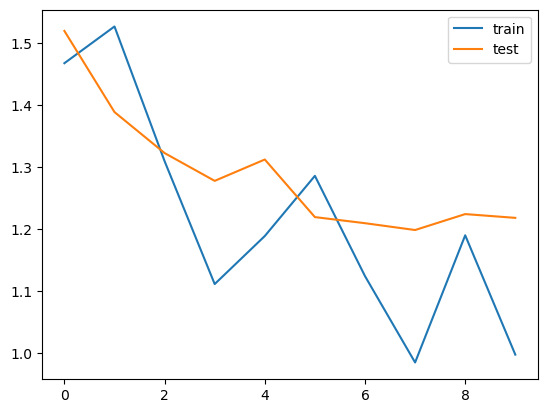

In [12]:
loss_plot(epochs,arr_loss_train)
loss_plot(epochs,arr_loss_test)
plt.legend(["train","test"])
